# Recurrent Neural Network (RNN) from Scratch

## Project Overview
This notebook implements a **sales forecasting** model using a Recurrent Neural Network built entirely from scratch (no TensorFlow/Keras). We use time series sales data to predict future product sales based on historical patterns.

### Dataset
- **Source**: [train.csv](train.csv) and [test.csv](test.csv)
- **Target**: `number_sold` (number of products sold)
- **Features**: Date, store ID, product ID, and historical sales
- **Type**: Time series sequential data

### Why RNN for Sales Forecasting?
Traditional neural networks treat all inputs independently and cannot capture temporal dependencies. Sales data has **sequential patterns** - today's sales depend on yesterday's. RNNs maintain a "memory" through hidden states, allowing them to learn from past time steps to predict future values.

**Key Advantage**: RNNs process sequences one element at a time while maintaining context from previous elements, making them ideal for time series, text, and any sequential data.

## What is a Recurrent Neural Network (RNN)?

**Recurrent Neural Networks** are a class of neural networks designed for sequential data. Unlike feedforward networks, RNNs have **loops** that allow information to persist.

### Core Concept: Hidden State (Memory)
At each time step `t`, the RNN processes:
- **Current input**: $x_t$ (e.g., sales on day t)
- **Previous hidden state**: $h_{t-1}$ (memory from past)
- **Produces**:
  - New hidden state: $h_t$ (updated memory)
  - Output: $y_t$ (prediction)

### Mathematical Formulation

#### 1. Hidden State Update
$$h_t = \tanh(W_{hh} \cdot h_{t-1} + W_{xh} \cdot x_t + b_h)$$

Where:
- $W_{hh}$: Weight matrix for hidden-to-hidden connections
- $W_{xh}$: Weight matrix for input-to-hidden connections
- $b_h$: Hidden bias
- $\tanh$: Activation function (squashes values to [-1, 1])

#### 2. Output Generation
$$y_t = W_{hy} \cdot h_t + b_y$$

Where:
- $W_{hy}$: Weight matrix for hidden-to-output connections
- $b_y$: Output bias

### Backpropagation Through Time (BPTT)
Training RNNs requires **unrolling** the network through time and computing gradients backwards through all time steps. This is computationally expensive but necessary to learn temporal patterns.

### Use Cases
- **Time Series Forecasting**: Stock prices, sales, weather
- **Natural Language Processing**: Text generation, sentiment analysis
- **Speech Recognition**: Converting audio to text
- **Video Analysis**: Action recognition

### RNN Challenges
1. **Vanishing Gradients**: Gradients can become very small in long sequences
2. **Exploding Gradients**: Gradients can become very large (solved via gradient clipping)
3. **Short-term Memory**: Standard RNNs struggle with long-term dependencies (LSTM/GRU solve this)

**Reference**: [Building RNN from Scratch](https://medium.com/analytics-vidhya/building-a-recurrent-neural-network-from-scratch-in-python-3b8e7d72c5a)

## Installation & Imports

In [1]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Data Loading & Exploration

First, we load the training and test datasets and understand their structure.

In [21]:
# Load training data
train_df = pd.read_csv('train.csv')
print("Training Data Shape:", train_df.shape)
print("\nFirst 10 rows:")
print(train_df.head(10))
print("\nDataset Info:")
print(train_df.info())
print("\nStatistical Summary:")
print(train_df.describe())

Training Data Shape: (230090, 4)

First 10 rows:
         Date  store  product  number_sold
0  2010-01-01      0        0          801
1  2010-01-02      0        0          810
2  2010-01-03      0        0          818
3  2010-01-04      0        0          796
4  2010-01-05      0        0          808
5  2010-01-06      0        0          812
6  2010-01-07      0        0          830
7  2010-01-08      0        0          812
8  2010-01-09      0        0          817
9  2010-01-10      0        0          832

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB
None

Statistical Summary:
               store    

In [3]:
# Load test data
test_df = pd.read_csv('test.csv')
print("Test Data Shape:", test_df.shape)
print("\nFirst 10 rows:")
print(test_df.head(10))
print("\nDate Range - Train:", train_df['Date'].min(), "to", train_df['Date'].max())
print("Date Range - Test:", test_df['Date'].min(), "to", test_df['Date'].max())

Test Data Shape: (25550, 4)

First 10 rows:
         Date  store  product  number_sold
0  2019-01-01      0        0          845
1  2019-01-02      0        0          851
2  2019-01-03      0        0          840
3  2019-01-04      0        0          842
4  2019-01-05      0        0          845
5  2019-01-06      0        0          855
6  2019-01-07      0        0          822
7  2019-01-08      0        0          850
8  2019-01-09      0        0          868
9  2019-01-10      0        0          849

Date Range - Train: 2010-01-01 to 2018-12-31
Date Range - Test: 2019-01-01 to 2019-12-31


### Exploratory Data Analysis (EDA)

We now visualize the sales patterns to understand trends and seasonality.

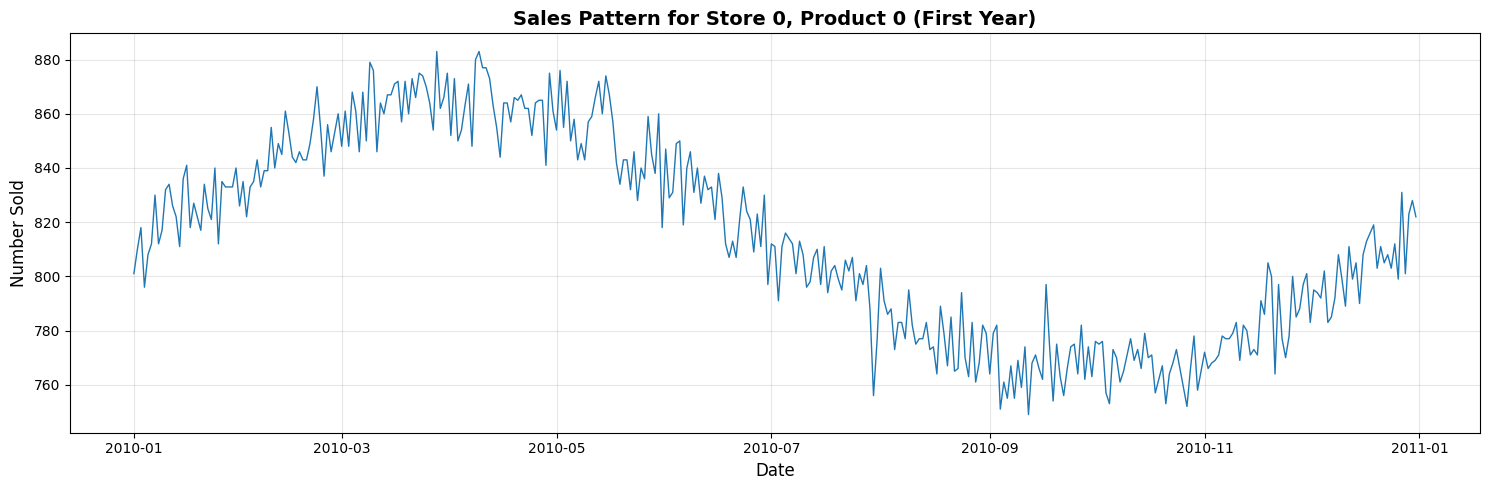

Average Sales: 780.93
Std Dev: 204.10
Min Sales: 238
Max Sales: 1205


In [4]:
# Convert Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Plot sales over time for a sample store-product combination
sample_data = train_df[(train_df['store'] == 0) & (train_df['product'] == 0)].head(365)

plt.figure(figsize=(15, 5))
plt.plot(sample_data['Date'], sample_data['number_sold'], linewidth=1)
plt.title('Sales Pattern for Store 0, Product 0 (First Year)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Sold', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average Sales: {train_df['number_sold'].mean():.2f}")
print(f"Std Dev: {train_df['number_sold'].std():.2f}")
print(f"Min Sales: {train_df['number_sold'].min()}")
print(f"Max Sales: {train_df['number_sold'].max()}")

## Data Preprocessing for RNN

### Creating Sequences
RNNs require data in sequences. We'll create sequences of length `n` (lookback window) to predict the next value.

**Example**: If `sequence_length = 7`:
- Input: Sales from day 1-7 → Output: Sales on day 8
- Input: Sales from day 2-8 → Output: Sales on day 9

This sliding window approach allows the RNN to learn temporal patterns.

In [5]:
# Extract sales data (we'll focus on one store-product combination for simplicity)
# In practice, you would build separate models for each store-product or use store/product as features
train_sales = train_df[train_df['store'] == 0]['number_sold'].values
test_sales = test_df[test_df['store'] == 0]['number_sold'].values

print(f"Training samples: {len(train_sales)}")
print(f"Test samples: {len(test_sales)}")

# Reshape for scaling
train_sales = train_sales.reshape(-1, 1)
test_sales = test_sales.reshape(-1, 1)

Training samples: 32870
Test samples: 3650


### Feature Scaling

**Why Scale?**
- Neural networks converge faster with normalized inputs
- Prevents features with larger ranges from dominating
- MinMaxScaler transforms data to [0, 1] range

$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_sales)
test_scaled = scaler.transform(test_sales)

print(f"Original range: [{train_sales.min():.2f}, {train_sales.max():.2f}]")
print(f"Scaled range: [{train_scaled.min():.4f}, {train_scaled.max():.4f}]")

Original range: [546.00, 1066.00]
Scaled range: [0.0000, 1.0000]


### Sequence Generation Function

This function creates overlapping sequences from our time series data.

In [7]:
def create_sequences(data, sequence_length):
    """
    Create sequences for RNN training
    
    Parameters:
    -----------
    data : numpy array
        Time series data
    sequence_length : int
        Number of time steps to look back
        
    Returns:
    --------
    X : numpy array, shape (samples, sequence_length, features)
        Input sequences
    y : numpy array, shape (samples, features)
        Target values (next time step)
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Extract sequence
        sequence = data[i:i + sequence_length]
        # Target is the next value
        target = data[i + sequence_length]
        X.append(sequence)
        y.append(target)
    
    return np.array(X), np.array(y)

# Create sequences
SEQUENCE_LENGTH = 7  # Use 7 days to predict the next day
X_train, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQUENCE_LENGTH)

print(f"Training sequences shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Test sequences shape: {X_test.shape}")
print(f"Test targets shape: {y_test.shape}")
print(f"\nExample:")
print(f"Input (7 days): {X_train[0].flatten()}")
print(f"Target (day 8): {y_train[0]}")

Training sequences shape: (32863, 7, 1)
Training targets shape: (32863, 1)
Test sequences shape: (3643, 7, 1)
Test targets shape: (3643, 1)

Example:
Input (7 days): [0.49038462 0.50769231 0.52307692 0.48076923 0.50384615 0.51153846
 0.54615385]
Target (day 8): [0.51153846]


## RNN Implementation from Scratch

### Architecture Overview
Our RNN will consist of:
1. **Input Layer**: Accepts sequences of sales data
2. **RNN Layer**: Processes sequences with hidden state
3. **Output Layer**: Produces next-day prediction

### Class Components
- `__init__`: Initialize weights and biases
- `tanh` & `tanh_derivative`: Activation functions
- `forward`: Forward propagation through time
- `backward`: Backpropagation through time (BPTT)
- `train`: Training loop with gradient descent
- `predict`: Make predictions on new data

In [8]:
class SimpleRNN:
    """
    Simple Recurrent Neural Network implemented from scratch
    
    Architecture:
    - Input: (sequence_length, input_size)
    - Hidden: (hidden_size,) with recurrent connections
    - Output: (output_size,)
    """
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Initialize RNN parameters
        
        Parameters:
        -----------
        input_size : int
            Number of input features (1 for univariate time series)
        hidden_size : int
            Number of hidden units (controls model capacity)
        output_size : int
            Number of output features (1 for single-step prediction)
        learning_rate : float
            Learning rate for gradient descent
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights using Xavier/Glorot initialization
        # This helps prevent vanishing/exploding gradients
        
        # Input to hidden weights: (input_size, hidden_size)
        self.Wxh = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / (input_size + hidden_size))
        
        # Hidden to hidden weights: (hidden_size, hidden_size)
        self.Whh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / (hidden_size + hidden_size))
        
        # Hidden to output weights: (hidden_size, output_size)
        self.Why = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / (hidden_size + output_size))
        
        # Biases initialized to zeros
        self.bh = np.zeros((1, hidden_size))  # Hidden bias
        self.by = np.zeros((1, output_size))  # Output bias
        
        # For storing losses
        self.losses = []
        
    def tanh(self, x):
        """
        Hyperbolic tangent activation function
        Maps input to (-1, 1) range
        Formula: tanh(x) = (e^x - e^-x) / (e^x + e^-x)
        """
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        """
        Derivative of tanh for backpropagation
        Formula: d/dx tanh(x) = 1 - tanh²(x)
        """
        return 1 - np.tanh(x) ** 2
    
    def forward(self, X):
        """
        Forward propagation through time
        
        Parameters:
        -----------
        X : numpy array, shape (sequence_length, input_size)
            Input sequence
            
        Returns:
        --------
        y_pred : numpy array, shape (output_size,)
            Prediction for next time step
        hidden_states : list of numpy arrays
            Hidden states at each time step (needed for BPTT)
        """
        sequence_length = X.shape[0]
        
        # Initialize hidden state with zeros
        h = np.zeros((1, self.hidden_size))
        
        # Store hidden states for backpropagation
        hidden_states = [h]
        
        # Process each time step in the sequence
        for t in range(sequence_length):
            # Get input at time t: shape (1, input_size)
            x_t = X[t].reshape(1, -1)
            
            # Update hidden state:
            # h_t = tanh(x_t @ Wxh + h_{t-1} @ Whh + bh)
            h = self.tanh(np.dot(x_t, self.Wxh) + np.dot(h, self.Whh) + self.bh)
            
            hidden_states.append(h)
        
        # Generate output from final hidden state
        # y = h_final @ Why + by
        y_pred = np.dot(h, self.Why) + self.by
        
        return y_pred, hidden_states
    
    def backward(self, X, y_true, y_pred, hidden_states):
        """
        Backpropagation Through Time (BPTT)
        
        Computes gradients by unrolling the network and applying
        backpropagation backwards through all time steps
        
        Parameters:
        -----------
        X : numpy array, shape (sequence_length, input_size)
            Input sequence
        y_true : numpy array, shape (output_size,)
            True target value
        y_pred : numpy array, shape (output_size,)
            Predicted value
        hidden_states : list
            Hidden states from forward pass
            
        Returns:
        --------
        Gradients for all parameters (dWxh, dWhh, dWhy, dbh, dby)
        """
        sequence_length = X.shape[0]
        
        # Initialize gradients
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        
        # Output layer gradient
        # Loss = 1/2 * (y_true - y_pred)²
        # dL/dy = -(y_true - y_pred)
        dy = -(y_true - y_pred)
        
        # Gradients for output layer weights
        dWhy = np.dot(hidden_states[-1].T, dy)
        dby = dy
        
        # Gradient flowing back to hidden state
        dh_next = np.dot(dy, self.Why.T)
        
        # Backpropagate through time
        for t in reversed(range(sequence_length)):
            # Gradient through tanh activation
            # Current hidden state (before activation was applied)
            h_raw = np.dot(X[t].reshape(1, -1), self.Wxh) + \
                    np.dot(hidden_states[t], self.Whh) + self.bh
            
            # Apply tanh derivative
            dh = dh_next * self.tanh_derivative(h_raw)
            
            # Accumulate gradients
            dWxh += np.dot(X[t].reshape(1, -1).T, dh)
            dWhh += np.dot(hidden_states[t].T, dh)
            dbh += dh
            
            # Gradient for next time step (flowing to h_{t-1})
            dh_next = np.dot(dh, self.Whh.T)
        
        # Gradient clipping to prevent exploding gradients
        # Clip gradients to [-5, 5] range
        for grad in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(grad, -5, 5, out=grad)
        
        return dWxh, dWhh, dWhy, dbh, dby
    
    def update_weights(self, dWxh, dWhh, dWhy, dbh, dby):
        """
        Update weights using gradient descent
        
        Weight update rule: W = W - learning_rate * dW
        """
        self.Wxh -= self.learning_rate * dWxh
        self.Whh -= self.learning_rate * dWhh
        self.Why -= self.learning_rate * dWhy
        self.bh -= self.learning_rate * dbh
        self.by -= self.learning_rate * dby
    
    def train(self, X_train, y_train, epochs, verbose=True):
        """
        Train the RNN using gradient descent
        
        Parameters:
        -----------
        X_train : numpy array, shape (num_samples, sequence_length, input_size)
            Training sequences
        y_train : numpy array, shape (num_samples, output_size)
            Training targets
        epochs : int
            Number of training iterations
        verbose : bool
            Whether to print progress
        """
        num_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            total_loss = 0
            
            # Process each sample
            for i in range(num_samples):
                # Forward pass
                y_pred, hidden_states = self.forward(X_train[i])
                
                # Calculate loss (Mean Squared Error)
                loss = 0.5 * np.sum((y_train[i] - y_pred) ** 2)
                total_loss += loss
                
                # Backward pass
                dWxh, dWhh, dWhy, dbh, dby = self.backward(
                    X_train[i], y_train[i], y_pred, hidden_states
                )
                
                # Update weights
                self.update_weights(dWxh, dWhh, dWhy, dbh, dby)
            
            # Average loss for the epoch
            avg_loss = total_loss / num_samples
            self.losses.append(avg_loss)
            
            # Print progress
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
    
    def predict(self, X):
        """
        Make predictions on new data
        
        Parameters:
        -----------
        X : numpy array, shape (num_samples, sequence_length, input_size)
            Input sequences
            
        Returns:
        --------
        predictions : numpy array, shape (num_samples, output_size)
            Predicted values
        """
        predictions = []
        
        for i in range(X.shape[0]):
            y_pred, _ = self.forward(X[i])
            predictions.append(y_pred)
        
        return np.array(predictions).reshape(-1, self.output_size)

print("✓ RNN class implemented successfully!")

✓ RNN class implemented successfully!


## Model Training

### Hyperparameters
- **Hidden Size**: Number of neurons in hidden layer (controls model capacity)
- **Learning Rate**: Step size for gradient descent
- **Epochs**: Number of complete passes through training data

Now we train our RNN!

In [9]:
# Initialize RNN
INPUT_SIZE = 1      # Univariate time series (only sales numbers)
HIDDEN_SIZE = 32    # Number of hidden units
OUTPUT_SIZE = 1     # Predict single value (next day's sales)
LEARNING_RATE = 0.001
EPOCHS = 100

rnn = SimpleRNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    output_size=OUTPUT_SIZE,
    learning_rate=LEARNING_RATE
)

print(f"Model Architecture:")
print(f"- Input Size: {INPUT_SIZE}")
print(f"- Hidden Size: {HIDDEN_SIZE}")
print(f"- Output Size: {OUTPUT_SIZE}")
print(f"- Total Parameters: {(INPUT_SIZE * HIDDEN_SIZE) + (HIDDEN_SIZE * HIDDEN_SIZE) + (HIDDEN_SIZE * OUTPUT_SIZE) + HIDDEN_SIZE + OUTPUT_SIZE}")
print(f"\nStarting training...")

Model Architecture:
- Input Size: 1
- Hidden Size: 32
- Output Size: 1
- Total Parameters: 1121

Starting training...


In [10]:
# Train the model
rnn.train(X_train, y_train, epochs=EPOCHS, verbose=True)
print("\n✓ Training completed!")

Epoch 10/100, Loss: 0.000342
Epoch 20/100, Loss: 0.000313
Epoch 30/100, Loss: 0.000304
Epoch 40/100, Loss: 0.000299
Epoch 50/100, Loss: 0.000296
Epoch 60/100, Loss: 0.000294
Epoch 70/100, Loss: 0.000293
Epoch 80/100, Loss: 0.000292
Epoch 90/100, Loss: 0.000291
Epoch 100/100, Loss: 0.000291

✓ Training completed!


### Training Loss Visualization

Monitor how the loss decreases during training to ensure the model is learning.

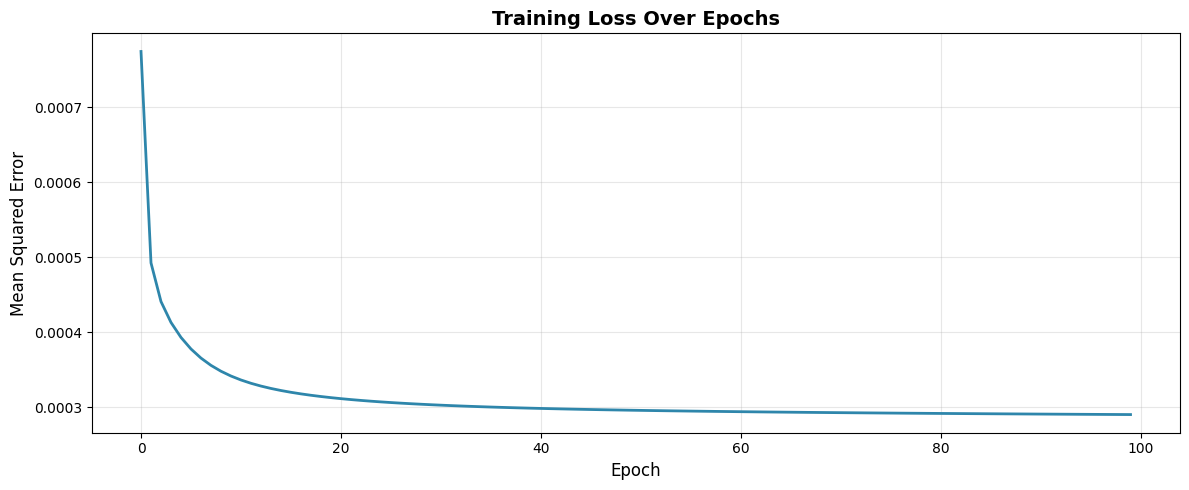

Initial Loss: 0.000775
Final Loss: 0.000291
Loss Reduction: 62.50%


In [11]:
# Plot training loss
plt.figure(figsize=(12, 5))
plt.plot(rnn.losses, linewidth=2, color='#2E86AB')
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial Loss: {rnn.losses[0]:.6f}")
print(f"Final Loss: {rnn.losses[-1]:.6f}")
print(f"Loss Reduction: {((rnn.losses[0] - rnn.losses[-1]) / rnn.losses[0] * 100):.2f}%")

## Model Evaluation

### Making Predictions
Evaluating our model on both training and test sets.

In [12]:
# Make predictions
train_predictions = rnn.predict(X_train)
test_predictions = rnn.predict(X_test)

print(f"Training predictions shape: {train_predictions.shape}")
print(f"Test predictions shape: {test_predictions.shape}")

# Inverse transform to get actual sales numbers
train_predictions_original = scaler.inverse_transform(train_predictions)
train_actual_original = scaler.inverse_transform(y_train)
test_predictions_original = scaler.inverse_transform(test_predictions)
test_actual_original = scaler.inverse_transform(y_test)

print("\nSample predictions (first 5):")
print("Actual    | Predicted")
print("-" * 25)
for i in range(5):
    print(f"{test_actual_original[i][0]:8.2f} | {test_predictions_original[i][0]:8.2f}")

Training predictions shape: (32863, 1)
Test predictions shape: (3643, 1)

Sample predictions (first 5):
Actual    | Predicted
-------------------------
  850.00 |   839.42
  868.00 |   844.57
  849.00 |   853.56
  856.00 |   850.68
  860.00 |   849.29


### Performance Metrics

Evaluate model performance using standard regression metrics:
- **RMSE (Root Mean Squared Error)**: Average prediction error in original units
- **MAE (Mean Absolute Error)**: Average absolute error
- **R² Score**: Proportion of variance explained (1.0 is perfect)

In [13]:
# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(train_actual_original, train_predictions_original))
train_mae = mean_absolute_error(train_actual_original, train_predictions_original)
train_r2 = r2_score(train_actual_original, train_predictions_original)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(test_actual_original, test_predictions_original))
test_mae = mean_absolute_error(test_actual_original, test_predictions_original)
test_r2 = r2_score(test_actual_original, test_predictions_original)

print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print("\nTRAINING SET:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

print("\nTEST SET:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("=" * 50)

# Calculate average sales for context
avg_sales = train_actual_original.mean()
print(f"\nAverage sales: {avg_sales:.2f}")
print(f"RMSE as % of average: {(test_rmse / avg_sales * 100):.2f}%")

MODEL PERFORMANCE METRICS

TRAINING SET:
  RMSE: 14.0117
  MAE:  10.8427
  R²:   0.9795

TEST SET:
  RMSE: 25.6254
  MAE:  15.4518
  R²:   0.9719

Average sales: 847.53
RMSE as % of average: 3.02%


### Prediction Visualization

Compare actual vs predicted values to visually assess model performance.

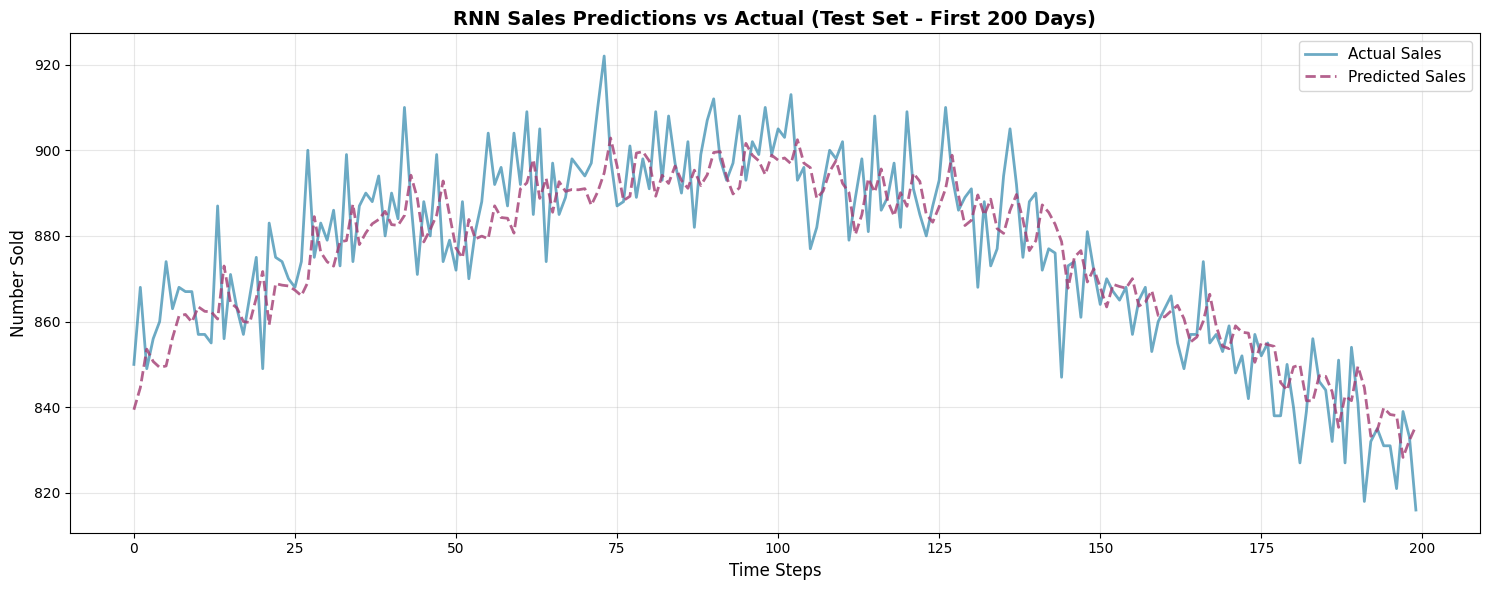

In [14]:
# Plot predictions vs actual (test set)
plt.figure(figsize=(15, 6))

# Plot first 200 test samples for clarity
n_samples = min(200, len(test_actual_original))

plt.plot(range(n_samples), test_actual_original[:n_samples], 
         label='Actual Sales', linewidth=2, color='#2E86AB', alpha=0.7)
plt.plot(range(n_samples), test_predictions_original[:n_samples], 
         label='Predicted Sales', linewidth=2, color='#A23B72', linestyle='--', alpha=0.8)

plt.title(f'RNN Sales Predictions vs Actual (Test Set - First {n_samples} Days)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Number Sold', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Scatter Plot: Predicted vs Actual

A diagonal line indicates perfect predictions. Points close to the line show good model performance.

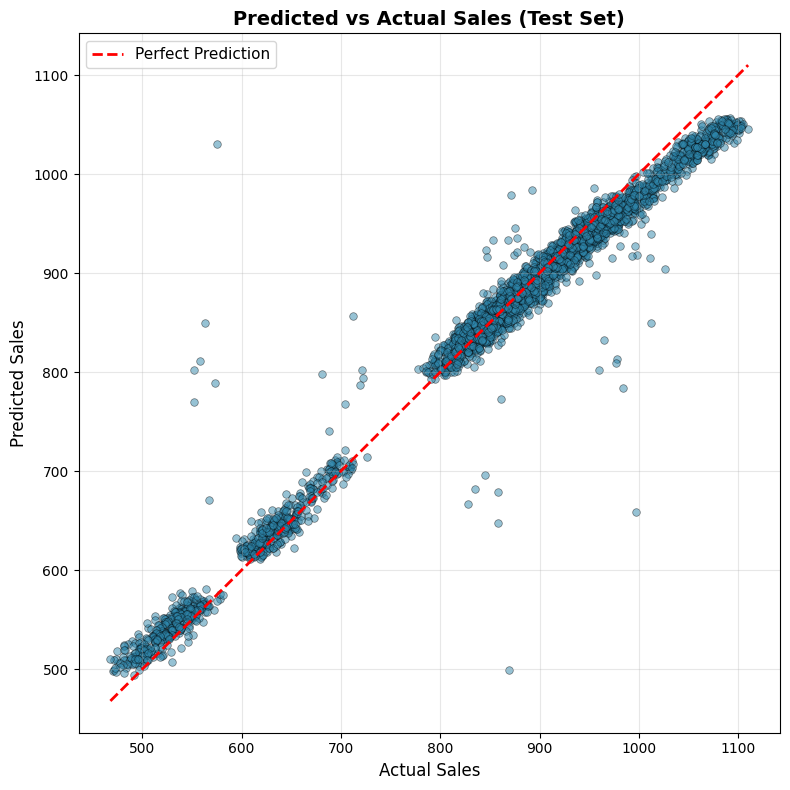

In [15]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(test_actual_original, test_predictions_original, 
            alpha=0.5, color='#2E86AB', s=30, edgecolors='black', linewidth=0.5)

# Perfect prediction line
min_val = min(test_actual_original.min(), test_predictions_original.min())
max_val = max(test_actual_original.max(), test_predictions_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 
         'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Sales (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Actual Sales', fontsize=12)
plt.ylabel('Predicted Sales', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**References**:
- [Building RNN from Scratch - Medium](https://medium.com/analytics-vidhya/building-a-recurrent-neural-network-from-scratch-in-python-3b8e7d72c5a)
- [Understanding BPTT](https://www.analyticsvidhya.com/blog/2021/07/understanding-backpropagation-through-time-in-rnns/)
- [Time Series Forecasting with RNNs](https://machinelearningmastery.com/time-series-forecasting-with-recurrent-neural-networks/)
